## Load Environment Variables

In [1]:
from pathlib import Path
from dotenv import load_dotenv

dotenv_path = Path("../help-desk-agent-flask-app/.env").resolve()
load_dotenv(dotenv_path=dotenv_path)

True

### Load Vector Store
help-desk-agent-flask-app/retriever.py

In [2]:
from langchain_chroma import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from pathlib import Path

CHROMA_DB_PATH = Path("../../datasets/help-desk-tickets/chroma_db").resolve()

# Loads the vector store from the specified directory if it already exists
VECTOR_STORE = Chroma(
    collection_name="helpdesk_tickets",
    embedding_function=GoogleGenerativeAIEmbeddings(model="models/embedding-001"),
    persist_directory="../../datasets/help-desk-tickets/chroma_db"
)

### Create RAG Tool
help-desk-agent-flask-app/rag_tool.py

In [3]:
from langchain_core.prompts import PromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables import RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_core.tools import convert_runnable_to_tool
from pydantic import BaseModel, Field

class InputSchema(BaseModel):
    question: str = Field(
        description=(
            "A natural language question about electronic health record (EHR) system "
            "tickets or issues, such as 'What is causing pharmacy work stoppages?'"
        )
    )

def get_top_k_documents(query: str):
    """Retrieve the top-k documents based on the hyde query."""
    top_k_documents = VECTOR_STORE.similarity_search(query, k=3)
    return top_k_documents

def format_documents(documents):
    """
    Format retrieved docs so that each begins with [TicketID],
    followed by EHR fields like Facility, EHRModule, etc.
    Ensures that TicketID is exposed in exactly bracketed form.
    """
    formatted = []
    for doc in documents:
        tid = doc.metadata.get("TicketID", "UNKNOWN_ID")
        content = doc.page_content
        formatted.append(f"TicketID: [{tid}]\n{content}")
    return "\n\n".join(formatted)

def get_rag_tool():
    """
    Create a RAG tool that uses the GoogleGenerativeAI model to generate responses
    """
    llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite", temperature=0.7)

    hyde_template = (
    "Based on the question: {question} "
    "Write a passage that could contain the answer to the question: " 
    )
    hyde_prompt = PromptTemplate(
        input_variables=["question"],
        template=hyde_template
    )

    get_top_k_documents_rl = RunnableLambda(get_top_k_documents)
    format_documents_rl = RunnableLambda(format_documents)

    hyde_chain = hyde_prompt | llm | StrOutputParser()
    retreival_chain = get_top_k_documents_rl | format_documents_rl | StrOutputParser()
    rag_chain = hyde_chain | retreival_chain

    rag_tool = convert_runnable_to_tool(
        runnable=rag_chain,
        name="ehr_ticket_rag_retriever",
        description=(
            "Useful for answering questions about EHR system issues using information extracted from support tickets. "
            "Given a question, it generates a hypothesis passage, retrieves relevant tickets, and formats their contents."
        ),
        args_schema=InputSchema
    )
    return rag_tool

#### Test rag_tool

In [4]:
from langchain_core.tools import BaseTool
rag_tool = get_rag_tool()
assert isinstance(rag_tool, BaseTool)
print(f"Tool name: {rag_tool.name}")
print(f"Tool name: {rag_tool.description}")
print(f"Tool schema: {rag_tool.args_schema.model_json_schema()}")

Tool name: ehr_ticket_rag_retriever
Tool name: Useful for answering questions about EHR system issues using information extracted from support tickets. Given a question, it generates a hypothesis passage, retrieves relevant tickets, and formats their contents.
Tool schema: {'properties': {'question': {'description': "A natural language question about electronic health record (EHR) system tickets or issues, such as 'What is causing pharmacy work stoppages?'", 'title': 'Question', 'type': 'string'}}, 'required': ['question'], 'title': 'InputSchema', 'type': 'object'}


In [5]:
# question = "Can you summarize what is causing some of the pharmacy work stoppage issues?"

# response = rag_tool.invoke({"question": question})
# print("Response:\n", response)

### ReACT Agent
help-desk-agent-flask-app/agent.py

In [6]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_google_genai import ChatGoogleGenerativeAI

def create_agent_with_memory():
    """
    Create a ReACT agent that uses the RAG tool for answering questions
    about EHR support tickets.
    """
    # Define the system prompt for the agent
    system_prompt = """
    You are a support assistant for EHR support tickets. Tools retrieve actual ticket records, and Ticket IDs are shown in square brackets — e.g. [c27b6138].

    When answering a user's question:
    - Summarize the explanation using Ticket IDs only in square brackets, never full metadata dump.
    - For example: “The issue appears in [c27b6138], [48cf2892], [0dd06ea2] — it's related to delays in the Pharmacy module…”
    - Always include at least one bracketed TicketID if relevant.
    - If no ticket matches, say “I couldn't find any relevant ticket for that question.”

    - Provide answers that are strictly based on ticket data. Do NOT hallucinate Ticket IDs.
    """
    llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite", temperature=1.0)
    rag_tool = get_rag_tool()
    tools = [rag_tool]
    memory = MemorySaver()
    agent = create_react_agent(
        model=llm, 
        tools=tools, 
        state_modifier=system_prompt,
        checkpointer=memory,
    )
    return agent

REACT_AGENT = create_agent_with_memory()

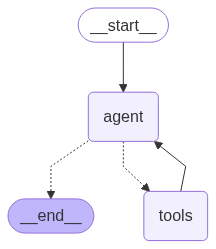

In [7]:
from IPython.display import Image, display

display(Image(REACT_AGENT.get_graph().draw_mermaid_png()))

## Memory Mechanism

In [8]:
from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory(return_messages=True)

C:\Users\Tstre\AppData\Local\Temp\ipykernel_22940\1448044083.py:3: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(return_messages=True)


In [17]:
config = {"configurable": {"thread_id": "tim-session-1"}}

input_message = (
    "How do you know what my name is?"
)

events = REACT_AGENT.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
)

for event in events:
    pass

event['messages'][-1].content

'The previous conversation showed that your name is Tim.'

'The pharmacy system experiences intermittent stalling, making it difficult for nurses to perform their duties. The exact cause is still under investigation, as indicated by the open and in-progress tickets. One ticket suggests backend maintenance as a possible cause, while another, already closed, simply states the issue was resolved per standard operating procedure.'